In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import collections
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import sequence

import tensorflow as tf

from tensorflow.keras import layers

from keras.utils.vis_utils import plot_model

from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Dropout, Embedding, concatenate
from keras.utils.vis_utils import plot_model

# Provides function for sliding window for training data of time series data https://www.tensorflow.org/tutorials/structured_data/time_series#the_weather_dataset
# How do we use our LSTM model as an input to a dense model with member features?
# Reference for classification with LSTM https://keras.io/examples/imdb_lstm/
# TODO Multi-input https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

/Users/wangzhengye/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Functional API Example

In [16]:
# Next number prediction!
# Creates a random incremental sequence of numbers from 0 to some integer
# Each observation has variable length, but padding is applied so observations start with 0's

batch_size = 100
num_batch = 250
num_integers = 10
max_integer = num_integers - 1
epochs = 3
lstm_units = 16
embedding_size = 16

# Generate Sequential input data of variable timestep length
# Example: [0, 1, 2, 3, 4]
x_train = []
y_train = []
for i in range(num_batch*batch_size):
    timestep_len = np.random.randint(max_integer)+1
    x_train.append(np.arange(0, timestep_len+1))
    y_obs = np.zeros(num_integers)
    y_obs[timestep_len] = 1
    y_train.append(y_obs)
x_train = np.array(x_train)

# Pad input so all observations are of same length
# Example: [0, 0, 0, 0, 0, 0, 1, 2, 3, 4]
x_train = sequence.pad_sequences(x_train, dtype='int32', maxlen = num_integers)
y_train = np.array(y_train)

data_in = Input(shape = (num_integers,))
x = Embedding(num_integers, embedding_size)(data_in)
#x = LSTM(lstm_units, return_sequences = True)(x) - stacked LSTM layers doesn't seem to help in this case
x = LSTM(lstm_units)(x)
x = Dropout(0.2)(x)
output = Dense(num_integers, activation='softmax')(x)

model = Model(data_in, output)
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

#model.summary()
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,verbose=1)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
25000/25000 [==============================] - 4s 162us/step - loss: 1.4083 - acc: 0.5432
Epoch 2/3
25000/25000 [==============================] - 3s 126us/step - loss: 0.3689 - acc: 0.9676
Epoch 3/3
25000/25000 [==============================] - 3s 122us/step - loss: 0.1373 - acc: 0.9951


## Simple Prediction

In [17]:
def prediction(num_to_predict):
    x_new = [np.arange(0, num_to_predict)]
    x_new = sequence.pad_sequences(x_new, dtype='int32', maxlen = 10)
    pred = model.predict(x_new) # Why does it always result in a prediction of 1?
    print(f"Attempting to predict {num_to_predict}: {np.argmax(pred)+1}")
    
# Create a new range of numbers from [0 to X) (not inclusive). Model should predict X
prediction(1) # Makes sense it can't predict 1 because it doesn't know when the sequence starts after the padding
prediction(2)
prediction(3)
prediction(4)
prediction(5)
prediction(9)
prediction(10)


Attempting to predict 1: 2
Attempting to predict 2: 2
Attempting to predict 3: 3
Attempting to predict 4: 4
Attempting to predict 5: 5
Attempting to predict 9: 9
Attempting to predict 10: 10


## Noisy Prediction

In [18]:
# Try a noisy example that isn't just a straight sequence of numbers
x_new = np.arange(0, 7)
x_new[6] = 8
x_new = [x_new]
x_new = sequence.pad_sequences(x_new, dtype='int32', maxlen = 10)
print(x_new)
pred = model.predict(x_new)
# Notice how it knows that the sequence looks more likely to lead up to 7 even though the last digit is 8
print(f"Attempting to predict: {np.argmax(pred)+1}")


[[0 0 0 0 1 2 3 4 5 8]]
Attempting to predict: 7


# Multi Input Example

In [7]:
# Dumb example, but as shown below, there are 2 inputs that go through seperate models and areconcatenated together

batch_size = 100
num_batch = 250
num_integers = 10
max_integer = num_integers - 1
epochs = 3
lstm_units = 16
embedding_size = 16

# Generate Sequential input data of variable timestep length
# Example: [0, 1, 2, 3, 4]
x_train_a = []
x_train_b = []
y_train = []
for i in range(num_batch*batch_size):
    timestep_len = np.random.randint(max_integer)+1
    x_train_a.append(np.arange(0, timestep_len+1))
    
    x_train_b.append(timestep_len*10)
    
    y_obs = np.zeros(num_integers)
    y_obs[timestep_len] = 1
    y_train.append(y_obs)
x_train_a = np.array(x_train_a)
x_train_b = np.array(x_train_b)

x_train_a = sequence.pad_sequences(x_train_a, dtype='int32', maxlen = num_integers)
y_train = np.array(y_train)

data_in_a = Input(shape = (num_integers,))
a = Embedding(num_integers, embedding_size)(data_in_a)
a = LSTM(lstm_units)(a)
a_mod = Model(data_in_a, outputs=a)

data_in_b = Input(shape = (1,))
b = Dense(5, activation='relu')(data_in_b)
b_mod = Model(data_in_b, outputs=b)

combined = concatenate([a_mod.output, b_mod.output])

c = Dropout(0.2)(combined)
c = Dense(num_integers, activation='softmax')(c)

model = Model(inputs=[a_mod.input, b_mod.input], outputs=c)
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

#model.summary()
model.fit([x_train_a, x_train_b], y_train, batch_size=batch_size, epochs=epochs,verbose=1)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 10, 16)       160         input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 16)           2112        embedding_2[0][0]                
__________________________________________________________________________________________________
dense_3 (D

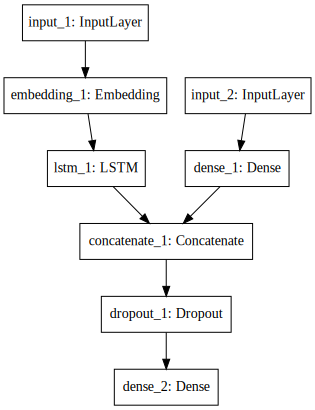

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))